In [20]:
from glob import glob
import numpy as np
import pandas as pd
import torch, os, cv2, torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import torchvision.transforms as T

In [21]:
class CustomDataset(Dataset):
    
    def __init__(self,root,  transformation=None ):
        super(). __init__()
        
        self.im_path = [im for im in sorted(glob(f"{root}/*/*.jpg"))]
        self.transformation = transformation
        self.class_name={}
        self.label =[]

        for idx, batch in enumerate(self.im_path):
            l = self.get_class(batch)
            self.label.append(l)
            self.uniq_class =[c for c in np.unique(list(self.label))]
            self.class_name ={keys: values for values , keys in enumerate(self.uniq_class)}

    def get_class(self, path):
         return os.path.dirname(path).split("\\")[-1].lower()

    def __len__(self): 
         return len(self.im_path)

    def __getitem__(self, ind):
         ims = self.im_path[ind]
         im = Image.open(ims).convert("RGB")

         gt = self.class_name[self.get_class(ims)]

         if self.transformation is not None:
             im = self.transformation(im)

         return im, gt
root = "realwaste-main/RealWaste"       
transformer = T.Compose([T.Resize((224, 224)),
                        T.ToTensor()])
data = CustomDataset(root = root , transformation = transformer)
clas_names = data.class_name
data[10]

(tensor([[[0.7333, 0.7333, 0.7843,  ..., 0.7176, 0.7216, 0.7216],
          [0.7686, 0.7412, 0.7333,  ..., 0.7216, 0.7059, 0.7098],
          [0.7373, 0.7176, 0.7490,  ..., 0.7216, 0.7059, 0.7255],
          ...,
          [0.8392, 0.8039, 0.7412,  ..., 0.6588, 0.6000, 0.5765],
          [0.8118, 0.7725, 0.7608,  ..., 0.6431, 0.6235, 0.5686],
          [0.7686, 0.8314, 0.8314,  ..., 0.6000, 0.5765, 0.5843]],
 
         [[0.7961, 0.8000, 0.8549,  ..., 0.7608, 0.7647, 0.7686],
          [0.8275, 0.8039, 0.8000,  ..., 0.7647, 0.7529, 0.7569],
          [0.7922, 0.7725, 0.8039,  ..., 0.7686, 0.7529, 0.7725],
          ...,
          [0.8902, 0.8510, 0.7882,  ..., 0.6745, 0.6157, 0.5843],
          [0.8588, 0.8196, 0.8078,  ..., 0.6588, 0.6353, 0.5765],
          [0.8157, 0.8784, 0.8784,  ..., 0.6157, 0.5843, 0.5922]],
 
         [[0.8353, 0.8392, 0.9020,  ..., 0.8314, 0.8353, 0.8314],
          [0.8745, 0.8510, 0.8549,  ..., 0.8314, 0.8157, 0.8196],
          [0.8510, 0.8314, 0.8667,  ...,

In [22]:
split =[0.8, 0.1, 0.1]
total_data = len(data)
tr_len = int(total_data*split[0])
ts_len = int(total_data*split[1])
val_len = total_data-(tr_len+ts_len)

tr_ds, ts_ds, val_ds = random_split(dataset=data, lengths=[tr_len, ts_len, val_len])
print(f"train len {tr_len}")
print(f"test len  {ts_len}")
print(f"val len   {val_len}")





train len 3801
test len  475
val len   476


In [23]:
def get_dataloader(root, bs, num_work):
    tr_dl = DataLoader(tr_ds, batch_size= bs, shuffle =True, num_workers = num_work)
    ts_dl = DataLoader(ts_ds, batch_size= bs,shuffle =False, num_workers = num_work)
    val_dl = DataLoader(val_ds, batch_size= bs, shuffle =False, num_workers = num_work)

    return tr_dl, ts_dl, val_dl
tr_dl, ts_dl, val_dl = get_dataloader(root="realwaste-main/RealWaste"  , bs = 32, num_work=0)

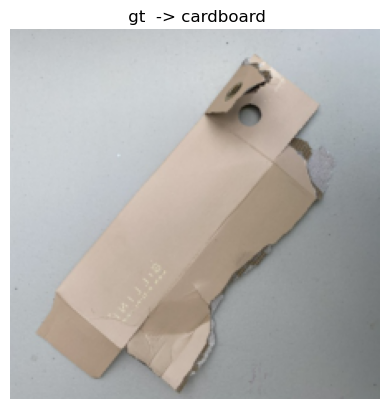

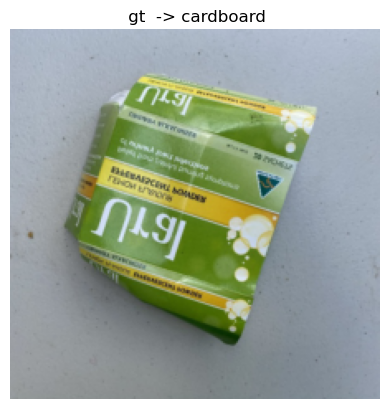

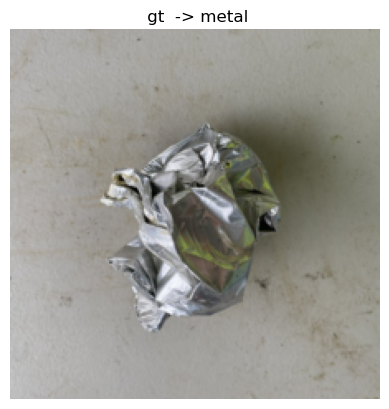

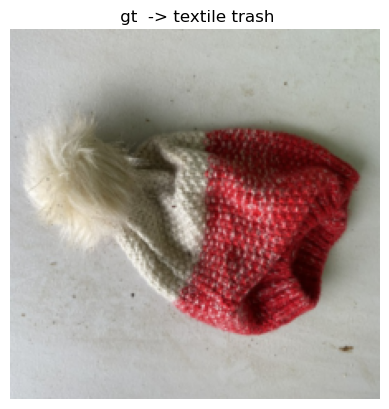

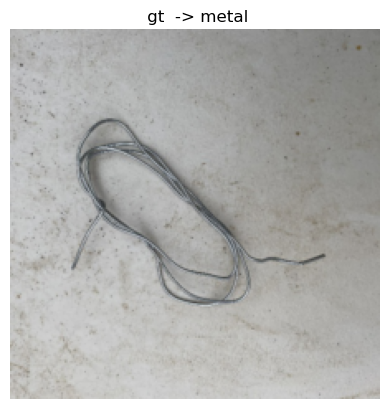

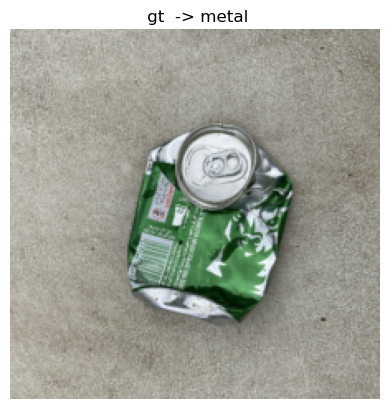

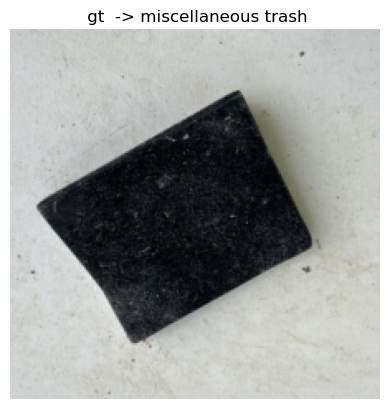

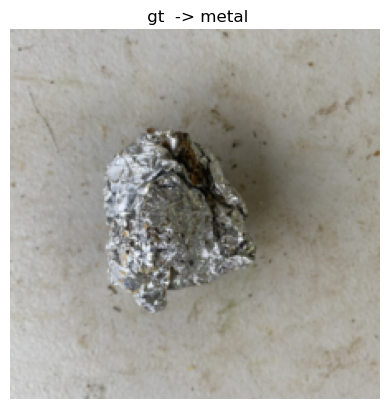

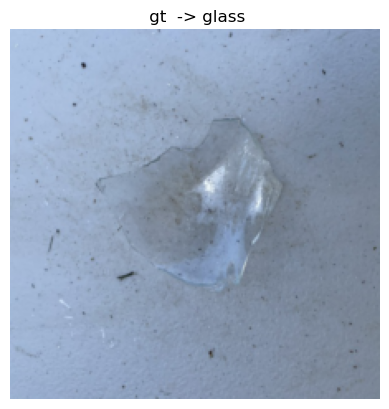

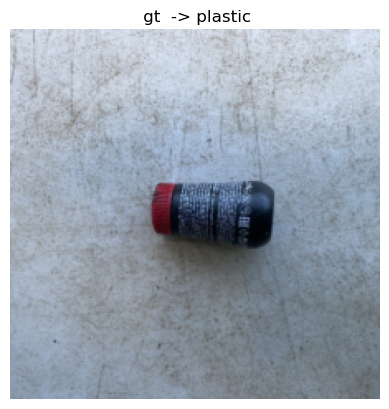

In [24]:
import random 
from matplotlib import pyplot as plt
def get_visualize(data, n_ims):
    class_n = list(clas_names.keys())
    
    # data_num = 15
    index = [random.randint(0, len(tr_ds)-1) for _ in range(n_ims)]
    for idx, ideks in enumerate(index):
        im , gt = tr_ds[ideks]

   
        plt.imshow((im*255).cpu().permute(2,1,0).numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f" gt  -> {class_n[gt]}")
        plt.show()
get_visualize(data = ts_ds, n_ims = 10)

In [25]:
!pip install timm

In [26]:
import timm
model  = timm.create_model(model_name = "rexnet_150", pretrained = True, num_classes = len(clas_names))
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.SGD(params = model.parameters(), lr=0.001)
model.to(device)

RexNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvNormAct(
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvNormAct(
        (conv): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): LinearBottlene

In [27]:
from tqdm import tqdm
def train(model, tr_dl, val_dl, epochs, device, loss_fc, opt, save_prefix):
  tr_acc_sc_ = []
  val_acc_sc_, val_epoc_loss_ = [],[]
  tr_total =0
  best_loss = np.inf
  decrease, not_improve, early_stop_threshold= 1,0,5

  print("Train is starting .....")

  for epoc in range(epochs):
      print(f"{epoc+1}- epoc is starting..")
      count=0
      tr_acc_sr, tr_total =0,0

      for idx, batch in enumerate(tqdm(tr_dl)):
          ims, gts = batch
          ims = ims.to(device)
          gts = gts.to(device)

          pred = model(ims)
          loss = loss_fc(pred, gts)

          tr_total+=ims.shape[0]
          pred_class = torch.argmax(pred, dim =1)
          count+=1
          tr_acc_sr+= (pred_class==gts).sum().item()

          optimazer.zero_grad()
          loss.backward()
          optimazer.step()

      model.eval()
      with torch.no_grad():
          val_acc_sc = 0
          val_total =0
          val_epoc_loss = 0

          for idx, batch in enumerate(tqdm(val_dl)):
              ims, gts = batch
              ims, gts = ims.to(device), gts.to(device)

              val_total+=ims.shape[0]

              pred = model(ims)


              pred_class = torch.argmax(pred, dim=1)
              val_acc_sc+=(pred_class==gts).sum().item()
              loss = loss_fc(pred, gts)
              val_epoc_loss+=loss.item()

              tr_ACC_SR = tr_acc_sr/tr_total
              VAL_acc_sc = val_acc_sc/val_total
              VAL_epoc_loss = val_epoc_loss/len(val_dl)


          print(f"{epoc+1} is finished..")
          print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
          print(f"{epoc+1} - epoc result:\n")
          print(f"{epoc+1}- epoc Train Accurancy score        -> {tr_ACC_SR:.3f}")
          print(f"{epoc+1}- epoc Validation Accurancy score   -> {VAL_acc_sc:.3f}")
          print(f"{epoc+1}- epoc Validation loss score        -> {VAL_epoc_loss:.3f}\n\n")


          tr_acc_sc_.append(tr_ACC_SR)
          val_acc_sc_.append(VAL_acc_sc)
          val_epoc_loss_.append(VAL_epoc_loss)

          if VAL_epoc_loss < best_loss:
              os.makedirs("best_model", exist_ok=True)
              best_loss = VAL_epoc_loss
              torch.save(model, f"best_model/{save_prefix}_best_model.pth")




  return {"tr_acc_sc": tr_acc_sc_, "val_acc_sc": val_acc_sc_, "val_epoc_loss": val_epoc_loss_}

In [28]:
result = train(model=model, tr_dl=tr_dl, val_dl=val_dl, epochs=15, device=device,
               loss_fc=loss_fn, opt=optimazer, save_prefix="musurlar")

Train is starting .....
1- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.57it/s]


1 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 - epoc result:

1- epoc Train Accurancy score        -> 0.409
1- epoc Validation Accurancy score   -> 0.534
1- epoc Validation loss score        -> 1.272


2- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.18it/s]


2 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 - epoc result:

2- epoc Train Accurancy score        -> 0.645
2- epoc Validation Accurancy score   -> 0.618
2- epoc Validation loss score        -> 1.008


3- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.99it/s]


3 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 - epoc result:

3- epoc Train Accurancy score        -> 0.718
3- epoc Validation Accurancy score   -> 0.653
3- epoc Validation loss score        -> 0.994


4- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.07it/s]


4 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 - epoc result:

4- epoc Train Accurancy score        -> 0.770
4- epoc Validation Accurancy score   -> 0.674
4- epoc Validation loss score        -> 0.890


5- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.05it/s]


5 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 - epoc result:

5- epoc Train Accurancy score        -> 0.805
5- epoc Validation Accurancy score   -> 0.628
5- epoc Validation loss score        -> 1.133


6- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.00it/s]


6 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6 - epoc result:

6- epoc Train Accurancy score        -> 0.827
6- epoc Validation Accurancy score   -> 0.761
6- epoc Validation loss score        -> 0.652


7- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.10it/s]


7 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
7 - epoc result:

7- epoc Train Accurancy score        -> 0.852
7- epoc Validation Accurancy score   -> 0.748
7- epoc Validation loss score        -> 0.702


8- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.12it/s]


8 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
8 - epoc result:

8- epoc Train Accurancy score        -> 0.868
8- epoc Validation Accurancy score   -> 0.773
8- epoc Validation loss score        -> 0.595


9- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.11it/s]


9 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
9 - epoc result:

9- epoc Train Accurancy score        -> 0.889
9- epoc Validation Accurancy score   -> 0.803
9- epoc Validation loss score        -> 0.577


10- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.04it/s]


10 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
10 - epoc result:

10- epoc Train Accurancy score        -> 0.900
10- epoc Validation Accurancy score   -> 0.773
10- epoc Validation loss score        -> 0.618


11- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.04it/s]


11 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
11 - epoc result:

11- epoc Train Accurancy score        -> 0.911
11- epoc Validation Accurancy score   -> 0.779
11- epoc Validation loss score        -> 0.611


12- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.01it/s]


12 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
12 - epoc result:

12- epoc Train Accurancy score        -> 0.924
12- epoc Validation Accurancy score   -> 0.796
12- epoc Validation loss score        -> 0.628


13- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.06it/s]


13 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
13 - epoc result:

13- epoc Train Accurancy score        -> 0.941
13- epoc Validation Accurancy score   -> 0.782
13- epoc Validation loss score        -> 0.631


14- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.02it/s]


14 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
14 - epoc result:

14- epoc Train Accurancy score        -> 0.945
14- epoc Validation Accurancy score   -> 0.813
14- epoc Validation loss score        -> 0.563


15- epoc is starting..


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.92it/s]

15 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
15 - epoc result:

15- epoc Train Accurancy score        -> 0.961
15- epoc Validation Accurancy score   -> 0.807
15- epoc Validation loss score        -> 0.539




In [29]:
result

{'tr_acc_sc': [0.4091028676664036,
  0.6445672191528545,
  0.7179689555380163,
  0.7695343330702447,
  0.8047882136279927,
  0.826624572480926,
  0.8524072612470402,
  0.8679294922388845,
  0.8887134964483031,
  0.8995001315443304,
  0.9113391212838726,
  0.9242304656669298,
  0.9410681399631676,
  0.9452775585372271,
  0.9607997895290713],
 'val_acc_sc': [0.5336134453781513,
  0.6176470588235294,
  0.6533613445378151,
  0.6743697478991597,
  0.6281512605042017,
  0.7605042016806722,
  0.7478991596638656,
  0.773109243697479,
  0.8025210084033614,
  0.773109243697479,
  0.7794117647058824,
  0.7962184873949579,
  0.7815126050420168,
  0.8130252100840336,
  0.8067226890756303],
 'val_epoc_loss': [1.2716039260228476,
  1.008045204480489,
  0.9941871364911398,
  0.8902694106101989,
  1.133025598526001,
  0.6523041546344757,
  0.7020479122797648,
  0.594728954633077,
  0.5770410299301147,
  0.6182745714982351,
  0.6110876818497976,
  0.6282523930072784,
  0.6308682084083557,
  0.5630234162

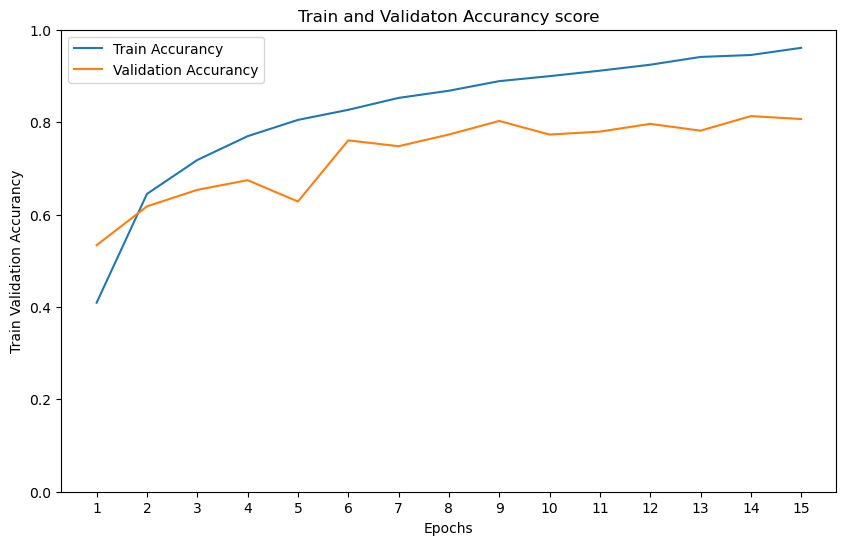

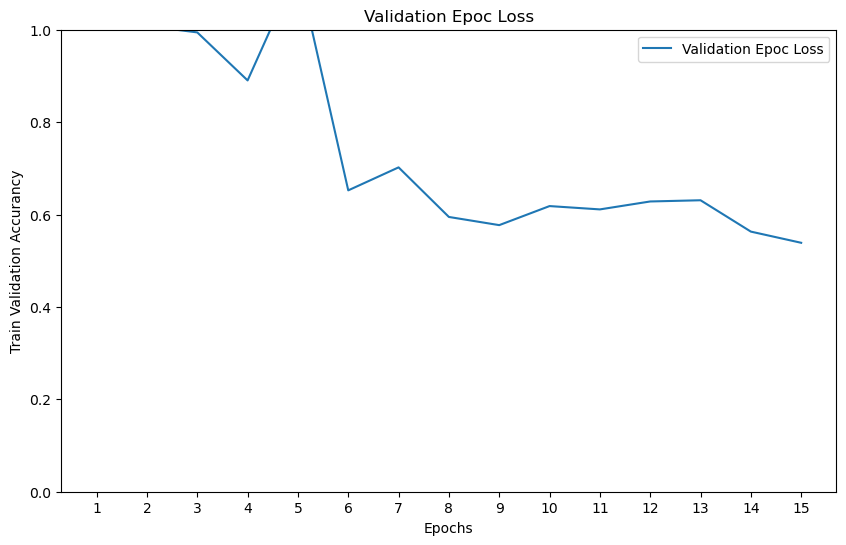

In [32]:
class plot():
    def __init__(self, res):

        plt.figure(figsize=(10, 6))
        plt.plot(res["tr_acc_sc"], label = 'Train Accurancy')
        plt.plot(res['val_acc_sc'], label = "Validation Accurancy")
        plt.title("Train and Validaton Accurancy score")
        plt.xlabel("Epochs")
        plt.xticks(np.arange(len(res['val_acc_sc'])), [i for i in range(1, len(res['val_acc_sc'])+1)])
        plt.ylabel("Train Validation Accurancy")
        plt.ylim(0,1)
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(res["val_epoc_loss"], label = 'Validation Epoc Loss')
        # plt.plot(res['val_acc_sc'], label = "Validation Accurancy")
        plt.title('Validation Epoc Loss')
        plt.xlabel("Epochs")
        plt.xticks(np.arange(len(res['val_epoc_loss'])), [i for i in range(1, len(res['val_epoc_loss'])+1)])
        plt.ylabel("Train Validation Accurancy")
        plt.ylim(0,1)
        plt.legend()
        plt.show()
plot(result)

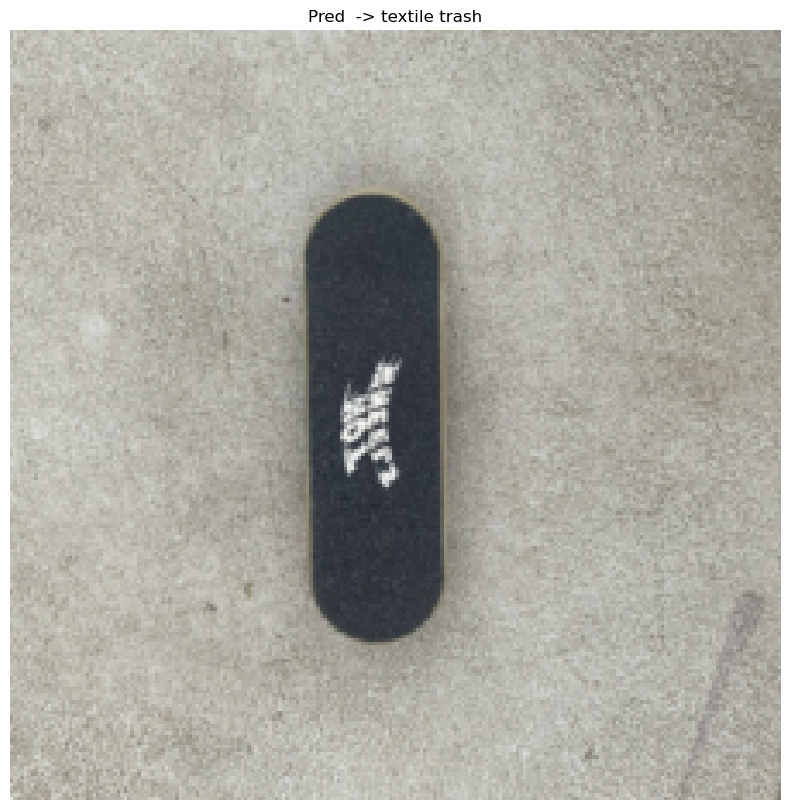

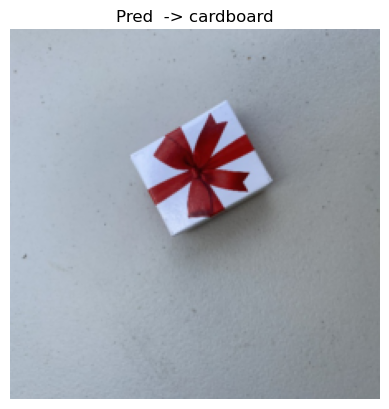

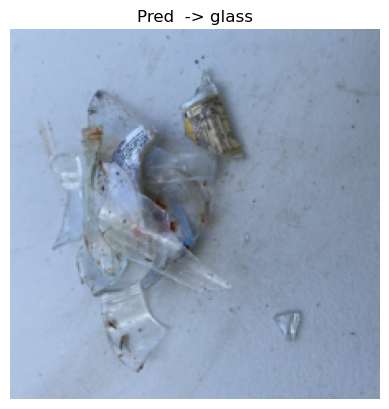

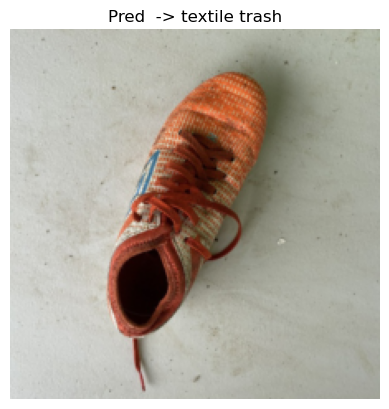

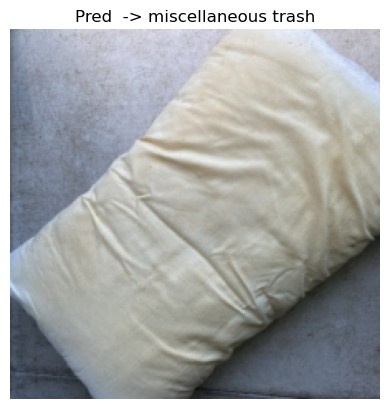

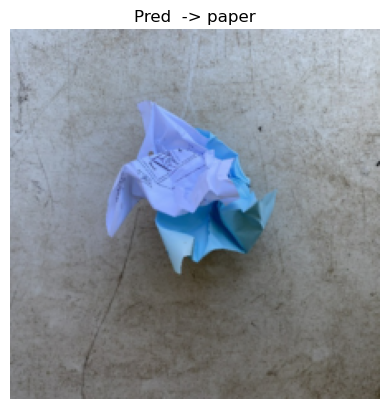

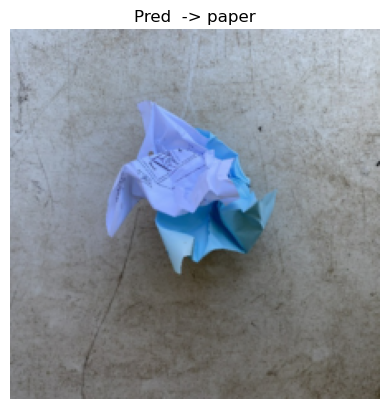

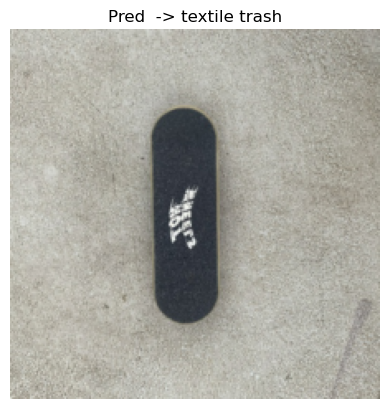

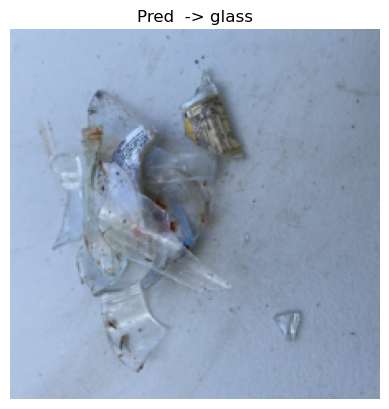

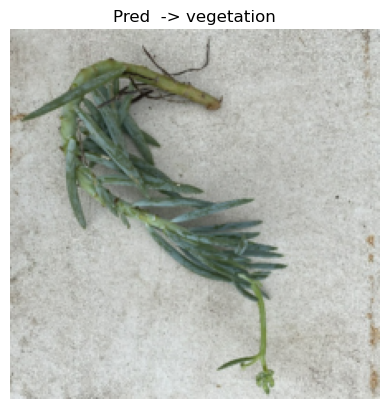

In [53]:
import random
def inference (data, model, device, image_num, class_name = None):
    preds, images = [], []

    for idx, batch in enumerate(data):
        if idx == image_num: break
        im = batch
        

        images.append(im)
        pred = torch.argmax(model(im[0].unsqueeze(dim=0).to(device)), dim = 1)
        preds.append(pred)

    plt.figure(figsize=(20, 10))
    idxs = [random.randint(0, len(images)-1) for _ in range(image_num)]

    for idx, indexs in enumerate(idxs):
        im = images[indexs]
        # plt.imshow((im*255).cpu().premute(2, 1, 0).numpy().astype("uint8"))
        plt.imshow((im[0].cpu() * 255).permute(2, 1, 0).numpy().astype("uint8"))

        plt.axis('off')
        plt.title(f"Pred  -> {class_name[preds[indexs]]}")
        plt.show()
model = torch.load("best_model/musurlar_best_model.pth")
inference(data = ts_ds, model = model.to(device), device = device, image_num=10, class_name = list(clas_names.keys()))
        